# __Appendix__:

## Contents:
- [1. Appendix](#appendix)
  - [1.1. Contents](#contents)
- [2. Introduction](#introduction)
- [3. Data](#data)
- [4. Model](#model)
  - [4.1. Setup for the analysis](#setup-for-the-analysis)
  - [4.2. Models sescription](#models-description)
     - [4.2.1. Mathematical formula for univariate model](#mathematical-formula-for-univariate-model)
     - [4.2.2. Stan code for univariate model](#stan-code-for-univariate-model)
     - [4.2.3 Validating the fit for univariate model](#validating-the-fit-for-univariate-model)
     - [4.2.4. Posterior predictive check for univariate model](#posterior-predictive-check-for-univariate-model)
     - [4.2.5. Fast LFO cross validationwith PSIS for univariate model](#cross-validation-for-univariate-model)
     - [4.2.6. Sensitivity analysis for univariate model](#sensitivity-analysis-for-univariate-model)
     - [4.2.7 Mathematical formula for multivariate model](#mathematical-formula-for-multivariate-model)
     - [4.2.8. Stan code for multivariate model](#stan-code-for-multivariate-model)
     - [4.2.9. Validating the fit for multivariate model](#validating-the-fit-for-multivariate-model)
     - [4.2.10. Posterior predictive checking for multivariate model](#posterior-predictive-checking-ofr-multivariate-model)
     - [4.2.11. Fast LFO cross validationwith PSIS for multivariate model](#cross-validation-for-multivariate-model)
     - [4.2.12. Sensitivity analysis for multivariate model](#sensitivity-analysis-for-multivariate-model)
  - [4.3. Model comparision](#model-comparision)
- [5. Discussion and Self-reflection](#discussion-and-self-reflection)
  - [5.1. Discussion](#discussion)
  - [5.2. Self-reflection](#self-relfection)

# __Introduction:__

- Motivation: 
Understand the development in the number of different diseases in an area would suggest us with problem inherited in that area, and help the medical staff to be better prepared. Bayesian method provides us with a more explainable model compared to methods used in machine learning, which makes it a good choice to be base model for this application. 


- Problem discussion: 

In this project I would model the death cases caused by different diseases in different state in US. The original idea of this project was to create a covariate model - predictor and predict, however the data about the predictors provided was quite limited. To be more specific, the data provided contains only the number of cases of death of different diseases by week but not other additional relevant informations. Furthermore, as a non-expert in this field, it is difficult to come up with a relevent predictors due to the number of diseases, since each disease's predictors could be different form each other.


- Modeling idea: 

From the difficulty presented above, I decided to treat the data as a stochastic process and use __classical time series method__ for modeling this process. Furthermore, from the correlation matrix of different diseases in an area - a state, I could see some diseases show strong correlation. Therefore, to capture these covariance I decide to use the __multivariate time series model__, and compare the result with the univariate model.


# __Data__

- Origin:

The data is provided by National Center for Health Statistics of US and downloaded from the link followed: https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr

- Description:

The data consist of states that data collected, the dates, and records of death by different diseases by the end of those dates. [Log transform and difference](#multivariate-model) had been applied to stationarize the data process.


- Previous analysis: 

The previous analysis is not presented, however the data had been downloaded 42 000 times.

# __Model__

In this project, two model would be discussed and compared: univariate and multivariate time series model as described in introduction-modeling idea.

## __Setup for the analysis__

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import stan
import nest_asyncio
import arviz as az
from statsmodels.graphics import tsaplots
import scipy.stats as st
import warnings
nest_asyncio.apply()
plt.ion()

DATA_DIR = "./Data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv"
STATE = 'Florida'
DISEASE = 'Septicemia (A40-A41)'

df = pd.read_csv(DATA_DIR) 
df = df.iloc[:, :17]  # Drop all the flag
df_usa = df[df['Jurisdiction of Occurrence'] == 'United States']
df = df[df['Jurisdiction of Occurrence'] != 'United States']
df = df.sort_values(['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week'])
sns.set_theme()
# Setup the data:
df_Florida = df[df['Jurisdiction of Occurrence'] == STATE].reset_index().drop('index', axis = 1)
ts = np.log(df_Florida.iloc[:, 6:]) # Take log transform - reduce the variance
ts = ts.diff(1)[1:]

## __Models Description__



### __Mathematical formula for univariate model__

/home/hieunguyen/Learning/BDA/Project/stan_env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


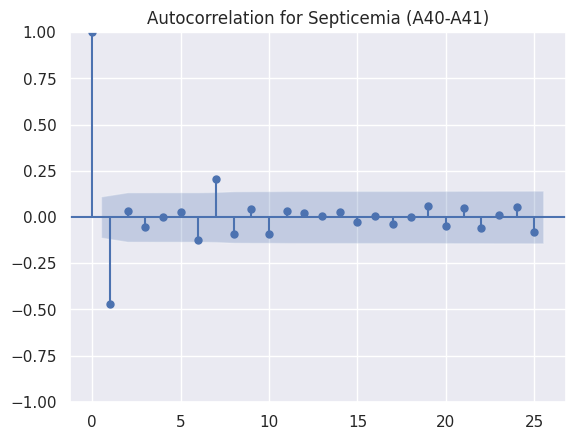

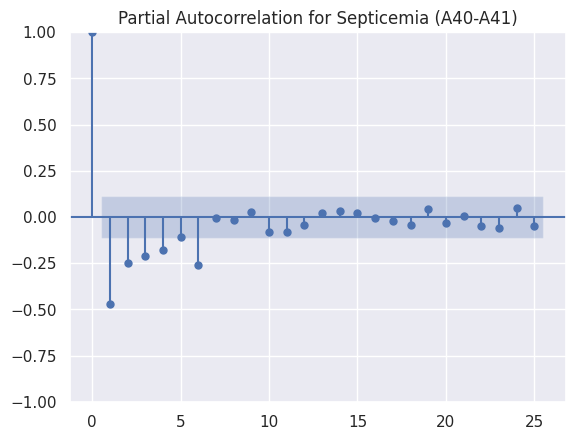

In [6]:
# THis part we would plot the autocorrelation and partial correlation to choose the model
# We only plot 1 time series.
for i in range(0, 1):
   tsaplots.plot_acf(ts.iloc[:, i], title= 'Autocorrelation for {}'.format(ts.columns[i]))
   tsaplots.plot_pacf(ts.iloc[:, i], title= 'Partial Autocorrelation for {}'.format(ts.columns[i]))

From the plot above we could see that the autocorrelation disposed after 1 and the partial auto correlation disposed exponentially, which is the properties of the MA(1) model.

**A mathematical representation of the model is the following:**


$x_{t} = \mu + \epsilon_{t} + \theta_{1}\epsilon_{t-1}$ 

$\epsilon_{t} \sim WN(0, \sigma^{2})$ 

==> $x_{t} \sim N(\mu + \theta * \epsilon_{t-1}, \sigma^{2})$


**Proper prior choice:**

The weakly informative prior choice could be reason as follow: 

- $\theta$ :
Since theta could only take value from -1 to 1 to ensure the convergence of the time series, as a result a good choice of prior for $\theta$ would be $N(0,2)$


- $\mu$: 
The plots of each disease do not show clear sign of decreasing or increasing, therefore the choice for expectation would be 0 (since we take the difference transform). For the variance, we do not expect the number of death to be varied more than 50%, and the large number of death is about 800, as a result the log transform of the difference would not varied more than: $(50 / 100) * log((50 / 100) * nofdeath) = 3$. As a result, the choice for the weakly informative prior is $N(0,3)$

- $\sigma$:
The choice for this parameter as suggested from Stan documentation is $Cauchy(0,2.5)$





### __Stan code for univariate model__

- Metadata:


The model had been built and sampled by stan file and pystan3 package. For convergence checking purpose, 4 different chains initialize and each chain sample 1000 samples for total of 4000.

- Detail:

The model chosen is MA(1), therefore, the observations had been divided for LFO validation purpose into (T and T_exclude). Constraint had been added for the lag coefficients to ensure the convergence of the time series. Lastly, log likehood of the observation had been computed for validation and comparision pupose. The detailed stan code could be found below.


In [7]:
# Read stan model from file

with open('./stan_files/arma.stan', 'r') as my_file:
    arma_models = my_file.read()

uni_variate_model = arma_models.split('//-----')[0]
multi_variate_model = arma_models.split('//-----')[1]

# Models
print(uni_variate_model)



data {
  int<lower=20> T;  // number of observations
  int T_exclude; // for validation
  vector[T + T_exclude] y;     // observation at time T
}
parameters {
  real mu;              // mean
  real<lower=0> sigma;  // error scale
  real<lower = -1, upper = 1> theta;      // lag coefficients
}
transformed parameters {
  vector[T+T_exclude] epsilon;    // error terms
  epsilon[1] = y[1] - mu;
  for (t in 2:(T+T_exclude)) {
    epsilon[t] = ( y[t] - mu - theta * epsilon[t - 1]);
  }
}
model {
  mu ~ normal(0, 3);
  theta ~ normal(0, 2);
  sigma ~ cauchy(0, 2.5);
  for (t in 2:T) {
    y[t] ~ normal(mu + theta * epsilon[t - 1] , sigma);
  }
}
generated quantities {
   vector[T + T_exclude - 1] ypred; // Since not include the first observation
   vector[T+T_exclude - 1] log_lik;

   for (t in 1:(T + T_exclude-1)) {
    ypred[t] = normal_rng(mu + theta * epsilon[t] , sigma);
    log_lik[t] = normal_lpdf(y[t] | mu+ theta * epsilon[t], sigma);
   }
}




In [8]:
%%capture

# Sample models:

N = ts.shape[0]
T_exclude = 1
T = N - T_exclude
y = ts[DISEASE].to_numpy()
uni_data = {'T': T, 'y': y, 'T_exclude': T_exclude}
uni_posterior = stan.build(uni_variate_model, data= uni_data);
fit_uni = uni_posterior.sample(num_chains= 4, num_samples = 1000);

### __Validating the fit for univariate model__

Convergence checking

In [9]:
# Checking the split R and Effective sample size.

print('Summary of the sampling')
print()
print(az.summary(fit_uni, var_names = ['mu', 'theta', 'sigma']))
print()
print('BFMI values')
print()
print(az.bfmi(fit_uni))

Summary of the sampling

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.001  0.002  -0.004    0.005      0.000    0.000    4305.0    3045.0   
theta -0.756  0.042  -0.831   -0.672      0.001    0.001    2212.0    2104.0   
sigma  0.175  0.007   0.162    0.188      0.000    0.000    2633.0    2443.0   

       r_hat  
mu       1.0  
theta    1.0  
sigma    1.0  

BFMI values

[1.16838468 1.1331385  1.01308195 1.07701464]


- The split R close to 1, which means the sampling is well converged for every parameters.


- BFMI quantifies how well momentum resampling matches the marginal energy distribution, BMFI smaller than 0.3 indicate poor sampling, according to this paper https://arxiv.org/pdf/1604.00695v1.pdf. 

- The least effective sample size for each parameter is around 2000, which is enough for modeling.

### __Posterior predictive check for univariate model__

- Visualization
   - pdf, cdf
   - marginal and CV predictive checing
   - Probability integral transform 

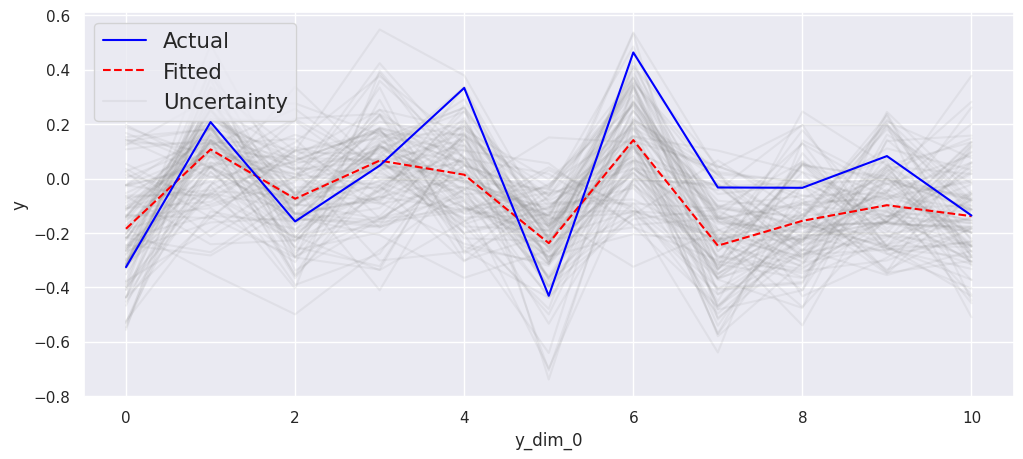

In [10]:
warnings.filterwarnings('ignore')

## Generate the model:


start = 300 # Plot part of the data 

fit_uni_inf = az.from_pystan(fit_uni) # Inference Data

obs_data = {
    "y": uni_data['y'][start+1:]
}
posterior_predictive = {
    "y": fit_uni_inf.posterior.ypred[:, :, start:]
 }

# Create new Inference Data for plotting the ttime series.

idata = az.from_dict(
    observed_data=obs_data,
    posterior_predictive=posterior_predictive,
)
ax = az.plot_ts(idata=idata, y="y")

From the visualization of the posterior draw, we could see that our model tends to converge to the mean while the observations are more varied, however this is a normal behavior of ARMA model and the posterior draws seem to be well fitted.

### __Cross-validation for univariate model__


This part is based on the instruction provided in this link: https://mc-stan.org/loo/articles/loo2-lfo.html

- Key idea: 


The idea is the normal Loo method would be misleading since we had made the past value affected by the future value. As the result, LFO would be our choice, and, to tackle the problem of refitting the data multiple times, we would follow the instruction on using the PSIS provided by the link above. 
In summary, we choose L as minimum number of observations needed for making prediction. We define $i^{*}=L$ as the current point of refit. Next, starting with $i=i^{*}+1$, we approximate each $p(y_{i+1:M}|y_{1:i})$ via: 


$p(y_{i+1: M} | y_{1:i}) \approx \frac{\sum_{s = 1}^{S} w_{i}^{(s)} p(y_{i+1: M} | y_{1:i}, \theta^{(s)})}{\sum_{s=1}^{S} w_{i}^{(s)}}$

then we compute the unnormalized importance ratios by:

$r_{i}^{(s)} \propto \prod_{j \in (i^{*} + 1): i}  p(y_{j} | y_{1: (j-1)}, \theta^{(s)})$

and smoothed them with PSIS. We continue to increase i and repeat this procedure until he k index of PSIS indicate poor sampling, then we would refit, update the model prior and compute the exact log likelihood.

- Key execution 


    - SamplingWrapper created for resampling purpose and getting the loglikelihood when k above the threshold of 0.7 (large K tail index means that there are many observations fall in the tail of the distribution - large ratio).

    - az.psislw function used for calculating the smoothed log ratio and the k value.

    - Helper functions are used to compute the elpd.

In [8]:
%%capture test
# Helper function:

# log(sum(exp(x)))
def log_sum_exp(x):
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

# log(mean(exp(x)))
def log_mean_exp(x):
    return log_sum_exp(x) - np.log(len(x))

# compute log of raw imporance ratio
# sum over observations not over posterior

def sum_log_ratios(loglik, ids = None):
    if not ids == None:
        loglik = loglik[:,list(ids)]  # To keep the dimension of the matrix
    return np.sum(loglik, axis = 1).reshape(1,-1)

# Create a SamplerWrapper for refitting purpose

dims = {'y': ['time'], 'ypred': ['time'], 'log_likelihood': ['time']}
idata_kwargs = {
    'posterior_predictive': 'ypred',
    'observed_data': 'y',
    'log_likelihood': ['log_lik'],
    'dims': dims
}
idata = az.from_pystan(posterior= fit_uni, posterior_model= uni_posterior, **idata_kwargs)
# Wrapper class: 
pystan_wrapper = az.PyStanSamplingWrapper(uni_variate_model, 
                                          idata_orig= idata, 
                                          idata_kwargs= idata_kwargs, 
                                          sample_kwargs= {'num_chains': 4, 'num_samples': 800})

## Estimating the LFO by Pareto:
L = 40
k_thresh = 0.7

app_elpds_1sap = np.full(N, np.nan, float)

# Initialize the process for i = L

past = L-1
oos = L
data = {'T': L, 'T_exclude': N - L, 'y': y}
fit_uni_past = pystan_wrapper.sample(data)
loglik = pystan_wrapper.get_inference_data(fit_uni_past)\
                                    .log_likelihood['log_lik']\
                                    .stack(__sample__=["chain", "draw"])\
                                    .data\
                                    .T

app_elpds_1sap[oos] = log_mean_exp(loglik[:, oos - 1] )
#Iterate over i > L:

i_refit = L-1

for i in range(L, N-1):
    past = i
    oos = i+1
    data = {'T': past + 1, 'T_exclude': N - (past + 1), 'y': y }
    
    logratio = sum_log_ratios(loglik, range(i_refit + 1, i + 1))
    smoothed_log_ratio = az.psislw(-logratio)[0]
    k = az.psislw(-logratio)[1][()] # Pareto tail index -if this value high then hihg number of obervations in the tail.
    if k > k_thresh:
        i_refit = i
        fit_uni_past = pystan_wrapper.sample(data)
        loglik = pystan_wrapper.get_inference_data(fit_uni_past)\
                                    .log_likelihood['log_lik']\
                                    .stack(__sample__=["chain", "draw"])\
                                    .data\
                                    .T
        app_elpds_1sap[oos] = log_mean_exp(loglik[:, oos - 1] )
    else:
        lw = smoothed_log_ratio / smoothed_log_ratio.sum()
        app_elpds_1sap[oos] = log_sum_exp(lw + loglik[:, oos - 1])



### __ELPD result univariate__

The elpd result for the lFO below would be used to compare to the mulitivariate model

In [9]:
print('Elpd of LFO: {}'.format(np.nansum(app_elpds_1sap)))

Elpd of LFO: 1784.9490788505789


### __Sensitivity analysis for univariate model__

In this part we would choose another reasonable prior for the parameters and plot the distribution of them to analyse the deviation.

Another choice for proper prior are:

Deviate the center for $\mu$:

$\mu \sim N(1,3) $ 

Deviate the variance for $\theta$:

$\theta \sim N(0,1)$

Deviate the shape for $\sigma$:

$\sigma \sim N(0,2)$

<AxesSubplot: title={'center': 'Sigma'}>

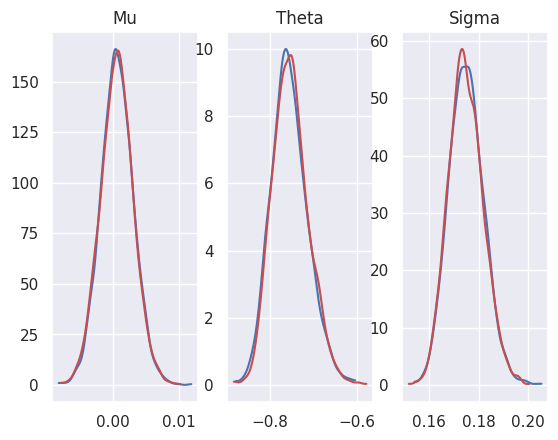

In [34]:
with open('./stan_files/sensitivity_analysis.stan', 'r') as my_file:
    arma_models = my_file.read()
uni_variate_modified = arma_models.split('//-----')[0]

uni_posterior_modified = stan.build(uni_variate_modified, data= uni_data)
fit_uni_modified = uni_posterior_modified.sample(num_chains= 4, num_samples = 1000)
fit_uni_inf_modified = az.from_pystan(fit_uni_modified) # Inference Data of modified data

mu_posterior = fit_uni_inf.posterior['mu'].values
theta_posterior = fit_uni_inf.posterior['theta'].values
sigma_posterior = fit_uni_inf.posterior['sigma'].values
mu_posterior_modified = fit_uni_inf_modified.posterior['mu'].values
theta_posterior_modified = fit_uni_inf_modified.posterior['theta'].values
sigma_posterior_modified = fit_uni_inf_modified.posterior['sigma'].values

# Set up for the plot:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, )
ax1.set_title('Mu')
ax2.set_title('Theta')
ax3.set_title('Sigma')
az.plot_kde(mu_posterior, ax= ax1)
az.plot_kde(mu_posterior_modified, ax = ax1, plot_kwargs={'c': 'r'})
az.plot_kde(theta_posterior, ax= ax2)
az.plot_kde(theta_posterior_modified, ax = ax2, plot_kwargs={'c': 'r'})
az.plot_kde(sigma_posterior, ax= ax3)
az.plot_kde(sigma_posterior_modified, ax = ax3, plot_kwargs={'c': 'r'})

From the posterior plots of different priors we could come to conclusion that the model would output approximately the same results for reasonable priors.

### __Mathematical formula for multivariate model__

The model chosen is VMA(1), which means we would model $y_{1,t}$ by the both the error at time t-1($\epsilon_{1,t-1} $) of that target time series and the error at time t-1 ($\epsilon_{2,t-1} $) of the covariate ones.

$y_{1, t} \sim N(\mu_{1} - \theta_{1,1} * \epsilon_{1,t-1} - \theta_{1,2} * \epsilon_{2, t-1}, \sigma_{1})$

$y_{2, t} \sim N(\mu_{2} - \theta_{1,1} * \epsilon_{1, t-1} - \theta_{1,2} * \epsilon_{2, t-1}, \sigma_{2})$

For similar reason for the prior of univariate model, we would choose a reasonal weak prior for the parameters as follow:

$\mu_{1} \sim N(0, 2)$

$\mu_{2} \sim N(0, 2)$

$\sigma_{1} \sim Cauchy(0, 2.5)$

$\sigma_{2} \sim Cauchy(0, 2.5)$

$\theta_{1,1} \sim N(0, 2)$

$\theta_{1,2} \sim N(0, 2)$

$\theta_{2,1} \sim N(0, 2)$

$\theta_{2,2} \sim N(0, 2)$


### __Stan code for multivariate model__

- Metadata:


The model had been built and sampled by stan file and pystan3 package. For convergence checking purpose, 4 different chains initialize and each chain sample 1000 samples for total of 4000.

- Detail:

The model chosen is VMA(1), therefore, the observations had been divided for LFO validation purpose into (T and T_exclude). Constraint had been added for the lag coefficients to ensure the convergence of the time series. Lastly, log likehood for the observations of the target disease are computed for comparision purpose. The detailed stan code could be found below.


In [10]:
print(multi_variate_model)


data {
  int<lower=20> T;
  int T_exclude;
  // int T_exclude;
  vector[T + T_exclude] y_1;
  vector[T + T_exclude] y_2;
}
parameters {
  real mu_1; 
  real mu_2;
  real<lower = -1, upper = 1> theta_1_1;
  real<lower = -1, upper = 1> theta_1_2;
  real<lower = -1, upper = 1> theta_2_1;
  real<lower = -1, upper = 1> theta_2_2;
  real<lower = 0> sigma_1;
  real<lower = 0> sigma_2; 
}
transformed parameters {
  vector[T + T_exclude] epsilon_1;
  vector[T + T_exclude] epsilon_2;
  epsilon_1[1] = y_1[1] - mu_1;
  epsilon_2[1] = y_2[1] - mu_2;
  for (t in 2:(T + T_exclude)) {
    epsilon_1[t] = y_1[t] - mu_1 - theta_1_1 * epsilon_1[t - 1] - theta_1_2 * epsilon_2[t-1];
    epsilon_2[t] = y_2[t] - mu_2 - theta_2_1 * epsilon_1[t - 1] - theta_2_2 * epsilon_2[t-1];
  }
}
model {
  mu_1 ~ normal(0, 2);
  mu_2 ~ normal(0, 2);
  sigma_1 ~ cauchy(0, 2.5);
  sigma_2 ~ cauchy(0, 2.5);
  theta_1_1 ~ normal(0, 2);
  theta_1_2 ~ normal(0, 2);
  theta_2_1 ~ normal(0, 2);
  theta_2_2 ~ normal(0, 2);

  for 

In [36]:
# Selecting the most correlated disease for each disease.

data_corr = ts.corr().values
all_diseases = ts.columns
most_correlated_dict = {}
np.fill_diagonal(data_corr, 0) # for finding most correlated between DIFFERENT columns

most_corr_index =  np.argmax(data_corr, axis = 0) # index of the most correlated column for each column.

for i in range(0, len(all_diseases)):
    orgin = all_diseases[i]
    target = all_diseases[most_corr_index[i]]
    most_correlated_dict[orgin] = (target, data_corr[i, most_corr_index[i]])


In [42]:
%%capture

# Sample models:


N = ts.shape[0]
T = N
y = ts.loc[:, [DISEASE, most_correlated_dict[DISEASE][0]]].to_numpy().T

multi_data = {'T': T-1, 'T_exclude': 1, 'y_1': y[0, :], 'y_2': y[1, :]}
multi_posterior = stan.build(multi_variate_model, data= multi_data)
fit_multi = multi_posterior.sample(num_chains= 4, num_samples = 1000)

### __Validating the fit for multivariate model__

In [13]:
# Checking the split R and Effective sample size.

print('Summary of the sampling')
print()
print(az.summary(fit_multi, var_names = ['mu_1', 'mu_2','theta_1_1', 'theta_1_2','theta_2_1','theta_2_2', 'sigma_1', 'sigma_2']))
print()
print('BFMI values')
print()
print(az.bfmi(fit_multi))

Summary of the sampling

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_1       0.001  0.002  -0.004    0.005      0.000    0.000    3696.0   
mu_2       0.000  0.002  -0.003    0.003      0.000    0.000    3854.0   
theta_1_1 -0.796  0.043  -0.874   -0.716      0.001    0.001    1637.0   
theta_1_2  0.147  0.050   0.052    0.241      0.001    0.001    1478.0   
theta_2_1  0.102  0.024   0.059    0.148      0.001    0.000    1916.0   
theta_2_2 -0.833  0.035  -0.897   -0.766      0.001    0.001    1500.0   
sigma_1    0.173  0.007   0.161    0.186      0.000    0.000    2343.0   
sigma_2    0.112  0.005   0.104    0.121      0.000    0.000    2733.0   

           ess_tail  r_hat  
mu_1         2627.0    1.0  
mu_2         2651.0    1.0  
theta_1_1    1811.0    1.0  
theta_1_2    1875.0    1.0  
theta_2_1    2194.0    1.0  
theta_2_2    1788.0    1.0  
sigma_1      2374.0    1.0  
sigma_2      2225.0    1.0  

BFMI values

[0.95341147 0.98718611 0.91868583

- The split R close to 1, which means the sampling is well converged for every parameters.


- The BFMI indices of the fit are all above 0.8, which are acceptable. BFMI quantifies how well momentum resampling matches the marginal energy distribution, BMFI smaller than 0.3 indicate poor sampling, according to this paper https://arxiv.org/pdf/1604.00695v1.pdf. 

- The least effective sample size for the parameters is 750 at the first time sampling, which is quite low, as a result I have try to sample more to get the least ess more than 1000.

### __Posterior predictive checking ofr multivariate model__ 

Visulization of the fit is an effective way for posterior predictive checking.

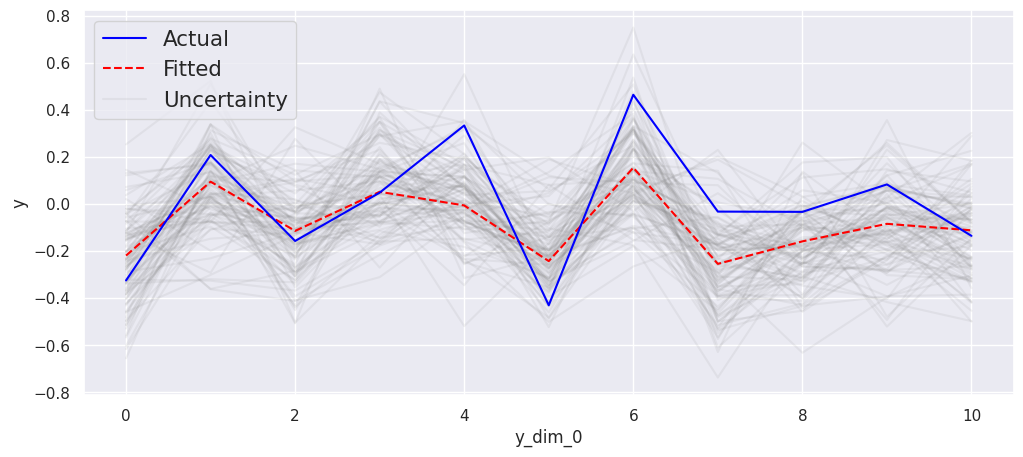

In [45]:
start = 300 # Plot part of the data 

fit_multi_inf = az.from_pystan(fit_multi) # Inference Data

obs_data = {
    "y": multi_data['y_1'][start+1:]
}
posterior_predictive = {
    "y": fit_multi_inf.posterior.ypred_1[:, :, start:]
 }

# Create new Inference Data for plotting the ttime series.

idata = az.from_dict(
    observed_data=obs_data,
    posterior_predictive=posterior_predictive,
)
ax = az.plot_ts(idata=idata, y="y")

The same explaination (in the univariate model) applied for the acceptable of this posterior draw. The posterior draw plot seem to be more well fitted compared to the [univariate model](#3214-posterior-predictive-check).

### __Cross-validation for multivariate model__

We follow the same procedure as univariate model.

We would compute the ELPD of the LFO for this model and compare with the previous one to find out whether cooperating another correlated disease would help predicting the behaviour of the target disease better.

In [15]:
%%capture

dims = {'y_1': ['time'], 'y_2': ['time'], 'ypred_1': ['time'],
        'ypred_2': ['time'], 'log_likelihood': ['time']}

idata_kwargs = {
    'posterior_predictive': ['ypred_1', 'ypred_2'],
    'observed_data': ['y_1', 'y_2'],
    'log_likelihood': ['log_lik'],
    'dims': dims
}
idata = az.from_pystan(posterior= fit_multi, posterior_model= multi_posterior, **idata_kwargs)
# Wrapper class: 
pystan_wrapper = az.PyStanSamplingWrapper(multi_variate_model, 
                                          idata_orig= idata, 
                                          idata_kwargs= idata_kwargs, 
                                          sample_kwargs= {'num_chains': 4, 'num_samples': 1000})

## Estimating the LFO by Pareto:
L = 40
k_thresh = 0.7

app_elpds_multi_1sap = np.full(N, np.nan, float)

# Initialize the process for i = L

past = L-1
oos = L
data = {'T': L, 'T_exclude': N - L, 'y_1': y[0, :], 'y_2': y[1, :] }
fit_multi_past = pystan_wrapper.sample(data)
loglik = pystan_wrapper.get_inference_data(fit_multi_past)\
                                    .log_likelihood['log_lik']\
                                    .stack(__sample__=["chain", "draw"])\
                                    .data\
                                    .T

app_elpds_multi_1sap[oos] = log_mean_exp(loglik[:, oos - 1] )
#Iterate over i > L:

i_refit = L-1

for i in range(L, N-1):
    past = i
    oos = i+1
    data = {'T': past + 1, 'T_exclude': N - (past + 1), 'y_1': y[0, :], 'y_2': y[1, :] }
    
    logratio = sum_log_ratios(loglik, range(i_refit + 1, i + 1))
    smoothed_log_ratio = az.psislw(-logratio)[0]
    k = az.psislw(-logratio)[1][()] # Pareto tail index -if this value high then hihg number of obervations in the tail.
    if k > k_thresh:
        i_refit = i
        fit_multi_past = pystan_wrapper.sample(data)
        loglik = pystan_wrapper.get_inference_data(fit_multi_past)\
                                    .log_likelihood['log_lik']\
                                    .stack(__sample__=["chain", "draw"])\
                                    .data\
                                    .T
        app_elpds_multi_1sap[oos] = log_mean_exp(loglik[:, oos - 1] )
    else:
        lw = smoothed_log_ratio / smoothed_log_ratio.sum()
        app_elpds_multi_1sap[oos] = log_sum_exp(lw + loglik[:, oos - 1])

### __ELPD result multivariate__


In [16]:
print('Elpd of LFO: {}'.format(np.nansum(app_elpds_multi_1sap)))

Elpd of LFO: 1765.609975935245


### __Sensitivity analysis for multivariate model__

Same for univariate model:

Deviate the center for $\mu$:

$\mu_{1}, \mu_{2} \sim N(1,3) $ 

Deviate the variance for $\theta$:

$\theta_{1,1}, \theta_{1,2}, \theta_{2,1}, \theta_{2,2} \sim N(0,1)$

Deviate the shape for $\sigma$:

$\sigma_{1}, \sigma_{2} \sim N(0,2)$

<AxesSubplot: title={'center': 'Sigma_1'}>

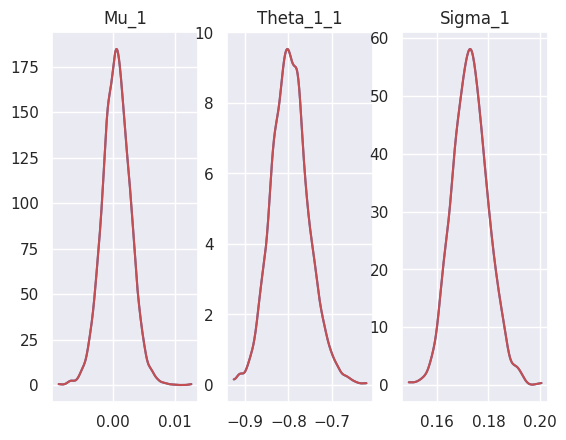

In [50]:
multi_variate_modified = arma_models.split('//-----')[1]
multi_posterior_modified = stan.build(multi_variate_modified, data= multi_data)
fit_multi_modified = multi_posterior_modified.sample(num_chains= 4, num_samples = 1000)
fit_multi_inf_modified = az.from_pystan(fit_multi_modified) # Inference Data of modified data

mu_posterior = fit_multi_inf.posterior['mu_1'].values
theta_posterior = fit_multi_inf.posterior['theta_1_1'].values
sigma_posterior = fit_multi_inf.posterior['sigma_1'].values
mu_posterior_modified = fit_multi_inf_modified.posterior['mu_1'].values
theta_posterior_modified = fit_multi_inf_modified.posterior['theta_1_1'].values
sigma_posterior_modified = fit_multi_inf_modified.posterior['sigma_1'].values

# Set up for the plot:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, )
ax1.set_title('Mu_1')
ax2.set_title('Theta_1_1')
ax3.set_title('Sigma_1')
az.plot_kde(mu_posterior, ax= ax1)
az.plot_kde(mu_posterior_modified, ax = ax1, plot_kwargs={'c': 'r'})
az.plot_kde(theta_posterior, ax= ax2)
az.plot_kde(theta_posterior_modified, ax = ax2, plot_kwargs={'c': 'r'})
az.plot_kde(sigma_posterior, ax= ax3)
az.plot_kde(sigma_posterior_modified, ax = ax3, plot_kwargs={'c': 'r'})

From the posterior plots of different priors we could come to conclusion that the model would output approximately the same results for reasonable priors.

## __Model comparision__

[ELPD for uni-variate model](#elpd-result-univariate)


[ELPD for multi-variate model](#elpd-result-multivariate)


From the Elpd estimation of the LFO cross-validation we could come to conclusion that the multi-variate model is slightly better.

# __Discussion and Self-reflection__

## __Discussion__

- Issues: 

The issue for this project would be these models assumed to be non-volatile, and maybe the lack of the predictors which made us unable to make use of hierachical model despite the clear hierarchical structure in terms of geographic.

- Potential Improvement: 

Straight from the issues mentioned above, this project could be extended with a volatility model and another improvement could be the use of reliable predictors, which if could get access, a potential model could be the Generalised Poisson Model which oftene used for modeling count variables. Futhermore, this model could be used as a base model for some Machine Learning approach for time series such as SVR.

## __Self-relfection__

This project has been very beneficial for myself, some key ideas could be presented as follow:

- A good way to revise, deepen, and extend knowledge of all key concepts of both Bayesian Data Analysis and Prediction Time Series course theoretically.

- Practical skills with modeling and validating Bayes model with Stan, PyStan and Arviz library.

- Better understanding of the advantages of Bayes approach compared to frequentist.

- Learn how to use md file for report.
